In [1]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from copy import  deepcopy
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

In [53]:
import os
#os.chdir('/home/yash/Documents/EWC/Elastic-Weight-Consolidation')
from model import Model
import pdb

In [5]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
sess = tf.InteractiveSession()

# define input and target placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
#Rupesh added this part
#Help for tensorflow datasets apis
#https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py
print('Training examples: ',mnist.train.num_examples,'. X shape:', mnist.train.images.shape, '. Y shape:',mnist.train.labels.shape)
print('Testing examples: ',mnist.test.num_examples,'. X shape:', mnist.test.images.shape, '. Y shape:',mnist.test.labels.shape)

#Creating different tasks
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]

categorical_cols_train_y = []
categorical_cols_test_y = []
categorical_cols_train_x = {}
categorical_cols_test_x = {}
label_cols_train_y = {}
label_cols_test_y = {}

for task in task_labels:
    for label in task:
        categorical_cols_train_y.append(mnist.train.labels[:,label])
        categorical_cols_test_y.append(mnist.test.labels[:,label])

for indices,y_frame in enumerate(categorical_cols_train_y):
    categorical_cols_train_x[indices] = []
    label_cols_train_y[indices] = []
    
for indices,y_frame in enumerate(categorical_cols_test_y):
    categorical_cols_test_x[indices] = []
    label_cols_test_y[indices] = []
        
for indices,y_frame in enumerate(categorical_cols_train_y):
    for j,i in enumerate(y_frame):
        if i==1:
            categorical_cols_train_x[indices].append(mnist.train.images[j])
            label_cols_train_y[indices].append(mnist.train.labels[j])
            
for indices,y_frame in enumerate(categorical_cols_test_y):
    for j,i in enumerate(y_frame):
        if i==1:
            categorical_cols_test_x[indices].append(mnist.test.images[j])
            label_cols_test_y[indices].append(mnist.test.labels[j])

for indices,y_frame in enumerate(categorical_cols_train_y):
    categorical_cols_train_x[indices] = np.array(categorical_cols_train_x[indices])
    label_cols_train_y[indices] = np.array(label_cols_train_y[indices])
            
for indices,y_frame in enumerate(categorical_cols_test_y):
    categorical_cols_test_x[indices] = np.array(categorical_cols_test_x[indices])
    label_cols_test_y[indices] = np.array(label_cols_test_y[indices])
            
tasks_train={}
labels_train={}
print('Training set details:')
for indices,task in enumerate(task_labels):
    for j,i in enumerate(task):
        if j == 0: 
            tasks_train[indices] = categorical_cols_train_x[i]
            labels_train[indices] = label_cols_train_y[i]
        else:
            tasks_train[indices] = np.concatenate((tasks_train[indices],categorical_cols_train_x[i]))
            labels_train[indices] = np.concatenate((labels_train[indices],label_cols_train_y[i]))
    print('Task:',indices, tasks_train[indices].shape, labels_train[indices].shape)
    
tasks_test={}
labels_test={}
print('Testing set details:')
for indices,task in enumerate(task_labels):
    for j,i in enumerate(task):
        if j == 0: 
            tasks_test[indices] = categorical_cols_test_x[i]
            labels_test[indices] = label_cols_test_y[i]
        else:
            tasks_test[indices] = np.concatenate((tasks_test[indices],categorical_cols_test_x[i]))
            labels_test[indices] = np.concatenate((labels_test[indices],label_cols_test_y[i]))
    print('Task:',indices, tasks_test[indices].shape, labels_test[indices].shape)
    

#Shuffle the data and labels for precise training.
for task in tasks_train.keys():
    shuffle_index = np.arange(tasks_train[task].shape[0])
    np.random.shuffle(shuffle_index)
    tasks_train[task] = tasks_train[task][shuffle_index]
    labels_train[task] = labels_train[task][shuffle_index]
    
    shuffle_index = np.arange(tasks_test[task].shape[0])
    np.random.shuffle(shuffle_index)
    tasks_test[task] = tasks_test[task][shuffle_index]
    labels_test[task] = labels_test[task][shuffle_index]

Training examples:  55000 . X shape: (55000, 784) . Y shape: (55000, 10)
Testing examples:  10000 . X shape: (10000, 784) . Y shape: (10000, 10)
Training set details:
Task: 0 (11623, 784) (11623, 10)
Task: 1 (11108, 784) (11108, 10)
Task: 2 (10294, 784) (10294, 10)
Task: 3 (11132, 784) (11132, 10)
Task: 4 (10843, 784) (10843, 10)
Testing set details:
Task: 0 (2115, 784) (2115, 10)
Task: 1 (2042, 784) (2042, 10)
Task: 2 (1874, 784) (1874, 10)
Task: 3 (1986, 784) (1986, 10)
Task: 4 (1983, 784) (1983, 10)


In [7]:
def mnist_imshow(img):
    plt.imshow(img.reshape([28, 28]), cmap='gray')
    plt.axis('off')

# return a new mnist dataset w/ pixels randomly permuted
def permute_mnist(mnist):
    perm_inds = list(range(mnist.train.images.shape[1]))
#     print (range(mnist.train.images.shape[1]))
    np.random.shuffle(perm_inds)
    mnist2 = deepcopy(mnist)
    sets = ["train", "validation", "test"]
    for set_name in sets:
        this_set = getattr(mnist2, set_name) # shallow copy
#         print (np.array([this_set.images[:,i] for i in [1,2,3,4]]).shape)
        #dafaq is with ._images, where did this shit come from, but okay moving on with lyf 
        this_set._images = np.transpose(np.array([this_set.images[:,c] for c in perm_inds]))
    return mnist2

def plot_test_acc(plot_handles):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel("Test Accuracy")
    plt.ylim(0, 1)
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [ ]:
def train_model(model, train_set, test_sets, num_iters=1000, disp_freq=50, lams=[0]):
    for l in range(len(lams)):
        model.restore(sess)
        
        if lams[l] == 0:
            model.vanilla_loss()
        else:
            model.set_ewc_loss(lams[l])

        test_accs = []
        for i in range(len(test_sets)):
            test_accs.append(np.zeros(int(num_iters / disp_freq)))
            
        colors = ['r', 'b', 'g', 'y','k']
        for continual_task in range(len(task_labels)):
            #train_batch = train_set.train.next_batch(100)
            #feed_dict = {x: train_batch[0], y_: train_batch[1]}
            for it in range(num_iters):
                feed_dict={x:tasks_train[continual_task], y_:labels_train[continual_task]}
                model.train_step.run(feed_dict=feed_dict)
            
                if it%disp_freq == 0:
                    plt.subplot(1, len(lams), l+1)
                    plots = []

                    for task in range(len(test_sets)):
                        index = int(it/disp_freq)
                        feed_dict = {x: test_sets[task].test.images, y_:test_sets[task].test.labels}
                        #feed_dict = {x:tasks_test[task], y_:labels_test[task]}
                        test_accs[task][index] = model.accuracy.eval(feed_dict=feed_dict)
                        task_char = chr(ord('A') +continual_task)
                        plot_h, = plt.plot(range(1, it+2, disp_freq), test_accs[task][:index+1], colors[continual_task], label = "Task" + task_char)
                        plots.append(plot_h)
    #                     print(test_accs)

                    plot_test_acc(plots)

                    if lams[l] == 0:
                        plt.title("Vanilla SGD")
                    else:
                        plt.title("EWC")

                    plt.gcf().set_size_inches(len(lams)*5, 3.5)

In [47]:
#manupulated the validation code: validation task by task        
def train_model(model, train_set, test_sets, num_iters=1000, disp_freq=50, lams=[0]):
    for l in range(len(lams)):
        model.restore(sess)
        
        if lams[l] == 0:
            model.vanilla_loss()
        else:
            model.set_ewc_loss(lams[l])

        test_accs = []
        for i in range(len(tasks_test)):
            test_accs.append(np.zeros(int(num_iters / disp_freq)))
            
        colors = ['r', 'b', 'g', 'y','k']
        for continual_task in range(len(task_labels)):
            #train_batch = train_set.train.next_batch(100)
            #feed_dict = {x: train_batch[0], y_: train_batch[1]}
            for it in range(num_iters):
                feed_dict={x:tasks_train[continual_task], y_:labels_train[continual_task]}
                model.train_step.run(feed_dict=feed_dict)
            
                if it%disp_freq == 0:
                    plt.subplot(1, len(task_labels), continual_task+1)
                    plots = []

                    for task in range(len(tasks_test)):
                        index = int(it/disp_freq)
                        #feed_dict = {x: test_sets[task].test.images, y_:test_sets[task].test.labels}
                        feed_dict = {x:tasks_test[task], y_:labels_test[task]}
                        test_accs[task][index] = model.accuracy.eval(feed_dict=feed_dict)
                        task_char = chr(ord('A') +task)
                        plot_h, = plt.plot(range(1, it+2, disp_freq), test_accs[task][:index+1], colors[task], label = "Task" + task_char)
                        plots.append(plot_h)
    #                     print(test_accs)

                    plot_test_acc(plots)

                    if lams[l] == 0:
                        plt.title("Vanilla SGD")
                    else:
                        plt.title("EWC")

                    plt.gcf().set_size_inches(15, 3.5)
                    plt.subplots_adjust(wspace = 0.4)

In [63]:
# instantiate new model
model = Model(x, y_) # simple 2-layer network
sess.run(tf.global_variables_initializer())

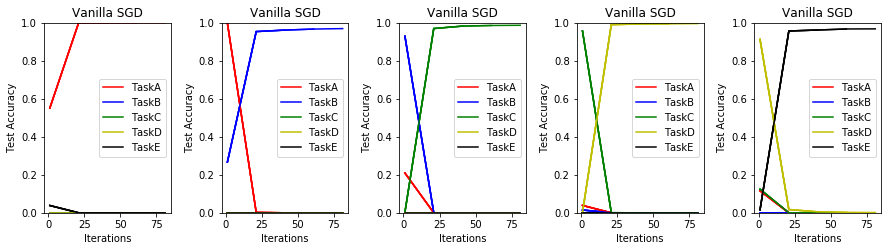

In [49]:
train_model(model, mnist, [mnist], 100, 20) #train model on task-A

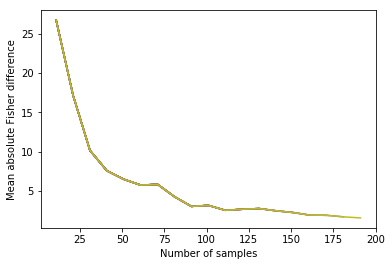

In [64]:
# Now compute the fisher and store the star variables, also create mnist 2 
fisher_inf = model.compute_fisher(mnist.validation.images, sess, num_samples=200, plot_diffs=True)
model.star() # store the star variables
mnist2 = permute_mnist(mnist) # get second mnist

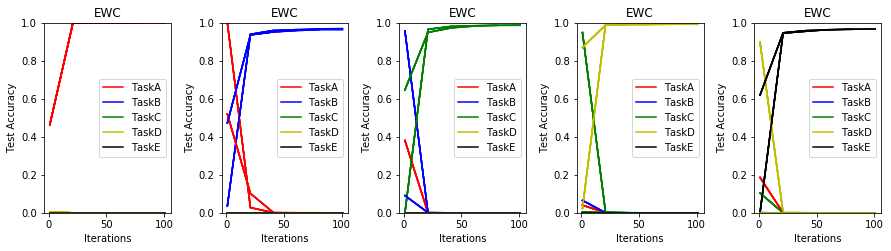

In [65]:
train_model(model, mnist2, [mnist, mnist2], 120, 20, [0, 20]) # train on task-B 